In [3]:
pip install optuna

In [4]:
!pip install -U transformers

In [5]:
pip install wandb

In [6]:
pip install wordcloud

In [7]:
import os
import kagglehub
import pandas as pd
import seaborn as sns
import plotly.express as px
import optuna
import wandb
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
data_path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")

print("Path to dataset files:", data_path)


Path to dataset files: /kaggle/input/covid-19-nlp-text-classification


In [10]:
train_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_train.csv"), encoding="latin1")
test_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_test.csv"), encoding="latin1")

In [11]:
print(train_df.shape, test_df.shape)

(41157, 6) (3798, 6)


In [12]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
train_df.dtypes

,0
UserName,int64
ScreenName,int64
Location,object
TweetAt,object
OriginalTweet,object
Sentiment,object


In [14]:
train_df['Sentiment'] = train_df['Sentiment'].astype('category')

Null count

In [15]:
train_df.isna().sum()

,0
UserName,0
ScreenName,0
Location,8590
TweetAt,0
OriginalTweet,0
Sentiment,0


Seems that only location has null values. So, for visualizations involving location, we'll remove them.

Number of unique classes:

In [16]:
train_df['Sentiment'].value_counts().index

CategoricalIndex(['Positive', 'Negative', 'Neutral', 'Extremely Positive',
                  'Extremely Negative'],
                 categories=['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'], ordered=False, dtype='category', name='Sentiment')

In [17]:
df=train_df.copy()

In [18]:
df['text_length'] = df['OriginalTweet'].apply(lambda x: len(x.split()))
print(df['text_length'].describe())

count    41157.000000
mean        30.500304
std         11.591172
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: text_length, dtype: float64


### לא עובד לפי הסדר- המקרא לא נכון

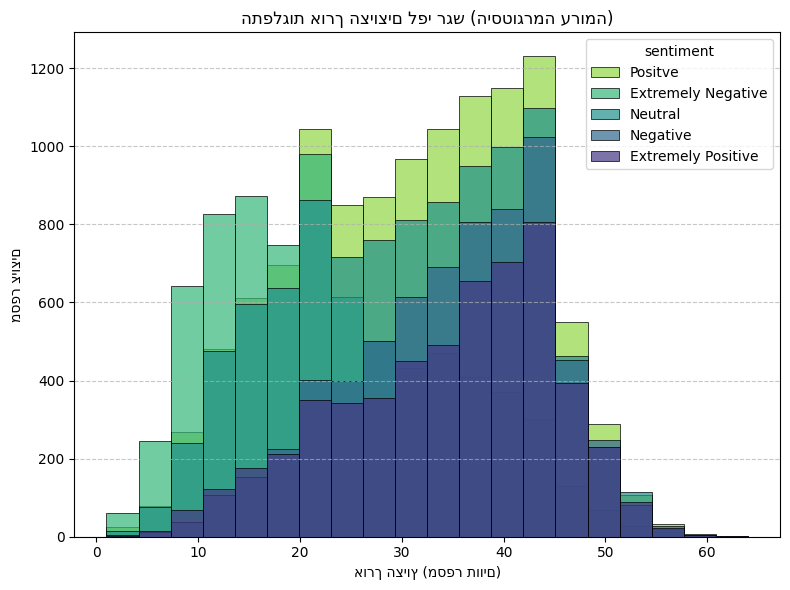

In [19]:
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x='text_length',
    hue='Sentiment',
    bins=20, # מספר סביבות ברירות המחדל של seaborn הוא לרוב סביר, אבל ניתן לשלוט בו
    multiple='layer', # אפשר גם 'dodge' (לצד זו), 'layer' (חופפות)
    stat='count', # מציג את הספירה בכל תא
    palette='viridis',
    alpha=0.7, # שקיפות
    edgecolor='black', # גבול סביב כל עמודה
    linewidth=0.5 # עובי הגבול
)

plt.title('התפלגות אורך הציוצים לפי רגש (היסטוגרמה ערומה)') # כותרת הגרף
plt.xlabel('אורך הציוץ (מספר תווים)') # תווית ציר X
plt.ylabel('מספר ציוצים') # תווית ציר Y
plt.grid(axis='y', linestyle='--', alpha=0.7) # הוספת קווי רשת לציר Y
plt.legend(title='sentiment', labels=['Positve','Extremely Negative','Neutral','Negative','Extremely Positive']) # הוספת כותרת ל-legend, אם כי הוא נוצר אוטומטית ע"י 'hue'.
plt.tight_layout() # התאמת הפריסה
plt.show()

In [20]:
sentiment_counts = train_df['Sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
fig = px.pie(sentiment_counts, values='Count', names='Sentiment', title='Distribution of Sentiments in Training Data', hole=0.4)
fig.show()

5 classes, seems quite balanced, if we see a bias towords the classes "positive" and "negative" we will have to consider weighted loss approch.
All in all, seems like the sentiment were not leaning toward negative emotions. on the contrary, there are more positive sentiment tweets than negative.

# Visualizations

## 1. Sentiment VS Geographical location

Clean dataframe for visualiations regarding location

In [21]:
SENTIMENT_TO_SCORE_MAPPING = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
    }

In [22]:
location_viz_df = train_df[~train_df["Location"].isna()]
location_viz_df["sentiment_score"] = location_viz_df["Sentiment"].map(SENTIMENT_TO_SCORE_MAPPING)

<ipython-input-22-68b6f35e4f20>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
LOCATION_IQ_TOKEN = 'pk.141e2e5711ccfbe2bea40ef7e857c721'
SAMPLE_SIZE = 30 # because of a ratelimit to the API - maximum 5K / day

In [24]:
map_viz_df = location_viz_df.sample(SAMPLE_SIZE, random_state=23)

In [25]:
'''
import requests
import time
from tqdm import tqdm

def geocode_locationiq(location):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": LOCATION_IQ_TOKEN,
        "q": location,
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if isinstance(data, list) and data:
            return float(data[0]['lat']), float(data[0]['lon'])
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None, None

# Apply with a delay to avoid rate limits (optional, but safe)
results = []
for loc in tqdm(map_viz_df['Location']):
    lat, lon = geocode_locationiq(loc)
    results.append((lat, lon))
    time.sleep(0.5)  # Optional throttle (LocationIQ free tier = 2 req/sec)

# Split the results into new columns
map_viz_df[['latitude', 'longitude']] = pd.DataFrame(results, index=map_viz_df.index)
'''


'\nimport requests\nimport time\nfrom tqdm import tqdm\n\ndef geocode_locationiq(location):\n    url = "https://us1.locationiq.com/v1/search.php"\n    params = {\n        "key": LOCATION_IQ_TOKEN,\n        "q": location,\n        "format": "json"\n    }\n    try:\n        response = requests.get(url, params=params)\n        response.raise_for_status()\n        data = response.json()\n        if isinstance(data, list) and data:\n            return float(data[0][\'lat\']), float(data[0][\'lon\'])\n        else:\n            return None, None\n    except Exception as e:\n        print(f"Error geocoding {location}: {e}")\n        return None, None\n\n# Apply with a delay to avoid rate limits (optional, but safe)\nresults = []\nfor loc in tqdm(map_viz_df[\'Location\']):\n    lat, lon = geocode_locationiq(loc)\n    results.append((lat, lon))\n    time.sleep(0.5)  # Optional throttle (LocationIQ free tier = 2 req/sec)\n\n# Split the results into new columns\nmap_viz_df[[\'latitude\', \'longit

In [26]:
'''
agg_df = map_viz_df.groupby(['latitude', 'longitude'], as_index=False)['sentiment_score'].sum()
fig = px.density_mapbox(
    agg_df,
    lat="latitude",
    lon="longitude",
    z="sentiment_score",
    radius=25,
    center={"lat": 30, "lon": 0},
    zoom=1,
    mapbox_style="carto-positron"
)
fig.show()
'''

'\nagg_df = map_viz_df.groupby([\'latitude\', \'longitude\'], as_index=False)[\'sentiment_score\'].sum()\nfig = px.density_mapbox(\n    agg_df,\n    lat="latitude",\n    lon="longitude",\n    z="sentiment_score",\n    radius=25,\n    center={"lat": 30, "lon": 0},\n    zoom=1,\n    mapbox_style="carto-positron"\n)\nfig.show()\n'

## 2. Sentiment accross dates:
Total sentiment score per day

In [27]:
timeline_sentiment_df = train_df.copy()
timeline_sentiment_df = timeline_sentiment_df[["TweetAt", "Sentiment"]]

In [28]:
timeline_sentiment_df['TweetAt'] = pd.to_datetime(timeline_sentiment_df['TweetAt'], format='%d-%m-%Y')
heatmap_data = (
    timeline_sentiment_df.groupby([timeline_sentiment_df['TweetAt'], 'Sentiment'])
    .size()
    .reset_index(name='count')
)

# Pivot to matrix format for heatmap
heatmap_pivot = heatmap_data.pivot(index='Sentiment', columns='TweetAt', values='count').fillna(0)

heatmap_pivot = heatmap_pivot.loc[
    sorted(heatmap_pivot.index, key=lambda s: SENTIMENT_TO_SCORE_MAPPING[s])
]

# Plot heatmap
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Date", y="Sentiment Score", color="Tweet Count"),
    x=[col.strftime('%Y-%m-%d') for col in heatmap_pivot.columns],
    y=heatmap_pivot.index,
    color_continuous_scale='YlOrRd',
    aspect='auto'
)

fig.update_layout(
    title="Sentiment Frequency Over Time",
    xaxis_title="Date",
    yaxis_title="Sentiment",
    height=400
)
fig.show()

<ipython-input-28-76641b986c34>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## 3. Word-cloud per Sentiment

In [29]:
word_cloud_df = train_df[["OriginalTweet", "Sentiment"]]

In [30]:
word_cloud_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


<ipython-input-31-918b84d860bf>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-918b84d860bf>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



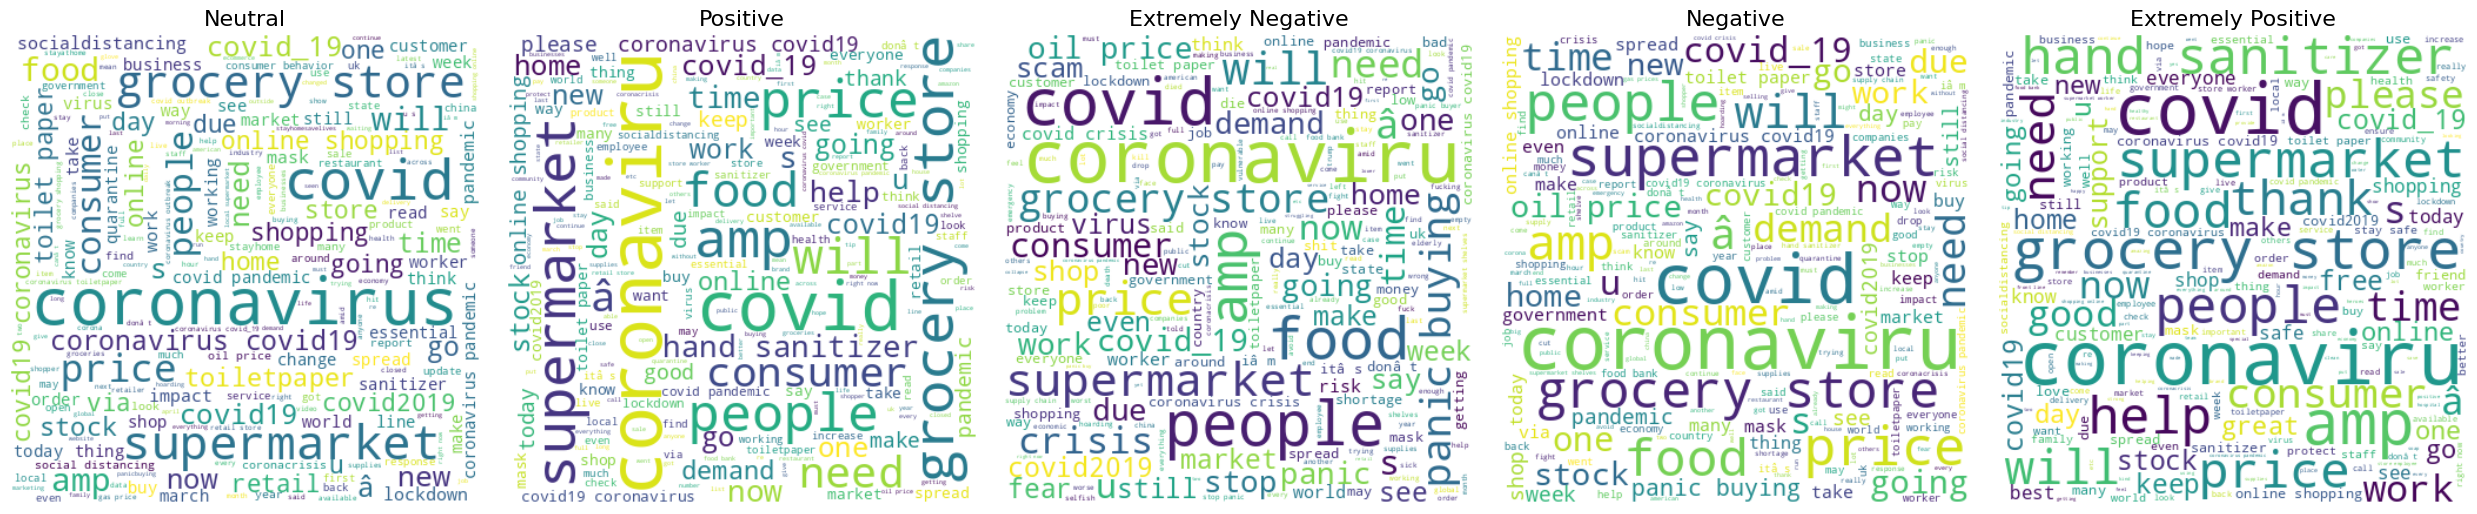

In [31]:


# lowercasing and basic cleaning
word_cloud_df['clean_text'] = word_cloud_df['OriginalTweet'].str.lower()

# Unique sentiments
sentiments = word_cloud_df['Sentiment'].unique()
to_remove = "http"

def delete_words_with_http(text, to_remove):

    if not isinstance(text, str):
        return text

    words = text.split() #

    kept_words = [word for word in words if to_remove not in word]

    return ' '.join(kept_words) #

word_cloud_df['clean_text'] = word_cloud_df['clean_text'].apply(lambda x: delete_words_with_http(x, to_remove))

# Plot word clouds
fig, axs = plt.subplots(1, len(sentiments), figsize=(5 * len(sentiments), 5))

if len(sentiments) == 1:
    axs = [axs]  # make iterable

for i, sentiment in enumerate(sentiments):
    text_blob = " ".join(word_cloud_df[word_cloud_df['Sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='viridis').generate(text_blob)

    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(sentiment, fontsize=16)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


The word cloud **did not show** any substantial differances between the topics of tweets under all sentiment categories

In [32]:
df_temp_indexed = train_df.copy()
df_temp_indexed.sample(8)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
26856,30655,75607,Katoomba ?? & Bangkok ??,02-04-2020,@lynlinking this type of demonisation &amp; st...,Extremely Negative
21048,24847,69799,NaN,25-03-2020,This is the reality of unstable and low income...,Extremely Negative
21441,25240,70192,Azania - Diepkloof??,25-03-2020,Eleven firms are under investigation for hikin...,Negative
5649,9448,54400,United Kingdom,19-03-2020,#coronavirus #UKGovernment #covid19UK #lockdow...,Negative
11341,15140,60092,"Sacramento, CA",20-03-2020,"@GavinNewsom @CDCgov A grocery store, Food Sou...",Neutral
14959,18758,63710,New Delhi | Nainital,22-03-2020,Smart!\r\r\n\r\r\nDanish Store Ends Hand Sanit...,Positive
31926,35725,80677,"Baltimore , MD",07-04-2020,I feel like I just won the lottery ????????\r\...,Extremely Positive
32039,35838,80790,Buffalo,07-04-2020,Trump canÂt figure out why the US Postal Serv...,Neutral


In [33]:
df_temp_indexed['TweetAt'] = pd.to_datetime(df_temp_indexed['TweetAt'])
# ---------------------------------------------------------

df_dt_indexed = df_temp_indexed.copy().set_index('TweetAt')

# המרת סנטימנט לערך מספרי לצורך חישוב ממוצע
sentiment_map = {'Extremely Positive': 2, 'Positive': 1, 'Neutral': 0, 'Negative': -1, 'Extremely Negative': -2}
df_dt_indexed['Sentiment'] = df_dt_indexed['Sentiment'].map(sentiment_map)

df_dt_indexed.head()


<ipython-input-33-8ba7ffaef77d>:1: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,UserName,ScreenName,Location,OriginalTweet,Sentiment
TweetAt,,,,,
2020-03-16,3799,48751,London,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
2020-03-16,3800,48752,UK,advice Talk to your neighbours family to excha...,1
2020-03-16,3801,48753,Vagabonds,Coronavirus Australia: Woolworths to give elde...,1
2020-03-16,3802,48754,NaN,My food stock is not the only one which is emp...,1
2020-03-16,3803,48755,NaN,"Me, ready to go at supermarket during the #COV...",-2


### להוריד- ניתוח אנומליות בצורה אחרת

In [34]:
'''
# חישוב ממוצע סנטימנט יומי באמצעות resample.
# הפונקציה resample('D') עובדת על DatetimeIndex ומקבצת את הנתונים לפי יום.
daily_avg_sentiment = df_dt_indexed['Sentiment'].resample('D').mean()

# מילוי ערכים חסרים (NaN) אם יש ימים ללא ציוצים, באמצעות מילוי קדימה (forward fill)
daily_avg_sentiment = daily_avg_sentiment.fillna(method='ffill')
# אפשר גם למלא באפס או בערך אחר: .fillna(0)

print("\nממוצע סנטימנט יומי (ערכים גבוהים יותר = חיובי יותר):")
print(daily_avg_sentiment.head())

# זיהוי אנומליות פשוט: ימים בהם השינוי המוחלט מהיום הקודם גדול מסטיית תקן אחת של השינויים
# (ניתן להתאים את הסף ואת גודל החלון של סטיית התקן)
sentiment_diff=daily_avg_sentiment.diff()
sentiment_diff_abs = daily_avg_sentiment.diff().abs()
# חישוב סף דינמי (לדוגמה, סטיית תקן אחת של ההפרשים, או ערך קבוע)
# נשתמש בחלון מתגלגל לחישוב סטיית תקן כדי שהיא תהיה רלוונטית יותר לשינויים מקומיים, אם כי לסט של הפרשים זה פחות קריטי.
threshold = sentiment_diff_abs.std()
# אם יש מעט נתונים, אפשר לשקול סף קבוע או גישה אחרת.
# לדוגמה, אם threshold יוצא NaN או 0 בגלל מיעוט נתונים/הפרשים, נגדיר סף מינימלי.
if pd.isna(threshold) or threshold == 0:
    threshold = 0.1# ערך ברירת מחדל אם לא ניתן לחשב סטיית תקן משמעותית

anomalies_dates = sentiment_diff_abs[sentiment_diff_abs > threshold].index
'''

'\n# חישוב ממוצע סנטימנט יומי באמצעות resample.\n# הפונקציה resample(\'D\') עובדת על DatetimeIndex ומקבצת את הנתונים לפי יום.\ndaily_avg_sentiment = df_dt_indexed[\'Sentiment\'].resample(\'D\').mean()\n\n# מילוי ערכים חסרים (NaN) אם יש ימים ללא ציוצים, באמצעות מילוי קדימה (forward fill)\ndaily_avg_sentiment = daily_avg_sentiment.fillna(method=\'ffill\')\n# אפשר גם למלא באפס או בערך אחר: .fillna(0)\n\nprint("\nממוצע סנטימנט יומי (ערכים גבוהים יותר = חיובי יותר):")\nprint(daily_avg_sentiment.head())\n\n# זיהוי אנומליות פשוט: ימים בהם השינוי המוחלט מהיום הקודם גדול מסטיית תקן אחת של השינויים\n# (ניתן להתאים את הסף ואת גודל החלון של סטיית התקן)\nsentiment_diff=daily_avg_sentiment.diff()\nsentiment_diff_abs = daily_avg_sentiment.diff().abs()\n# חישוב סף דינמי (לדוגמה, סטיית תקן אחת של ההפרשים, או ערך קבוע)\n# נשתמש בחלון מתגלגל לחישוב סטיית תקן כדי שהיא תהיה רלוונטית יותר לשינויים מקומיים, אם כי לסט של הפרשים זה פחות קריטי.\nthreshold = sentiment_diff_abs.std()\n# אם יש מעט נתונים, אפשר לשק

In [35]:
'''
# זיהוי תאריכים עם אנומליות חיוביות (עלייה חדה)
positive_anomalies_dates = sentiment_diff[sentiment_diff > threshold].index

# זיהוי תאריכים עם אנומליות שליליות (ירידה חדה)
negative_anomalies_dates = sentiment_diff[sentiment_diff <threshold].index

# --- יצירת הגרף ---
plt.figure(figsize=(15,7))
daily_avg_sentiment.plot(label='ממוצע סנטימנט יומי', color='dodgerblue', marker='.', linestyle='-', zorder=1)

# הדפסת האנומליות החיוביות
if not positive_anomalies_dates.empty:
    valid_positive_dates = [date for date in positive_anomalies_dates if date in daily_avg_sentiment.index]
    if valid_positive_dates:
        plt.scatter(valid_positive_dates, daily_avg_sentiment.loc[valid_positive_dates],
                    color='green', s=150, label='אנומליה חיובית (עלייה)', zorder=5, alpha=0.8)
        print("\nאנומליות חיוביות זוהו בתאריכים:")
        print(daily_avg_sentiment.loc[valid_positive_dates])
else:
    print("\nלא זוהו אנומליות חיוביות משמעותיות.")

# הדפסת האנומליות השליליות
if not negative_anomalies_dates.empty:
    valid_negative_dates = [date for date in negative_anomalies_dates if date in daily_avg_sentiment.index]
    if valid_negative_dates:
        plt.scatter(valid_negative_dates, daily_avg_sentiment.loc[valid_negative_dates],
                    color='red', s=150, label='אנומליה שלילית (ירידה)', zorder=5, alpha=0.8)
        print("\nאנומליות שליליות זוהו בתאריכים:")
        print(daily_avg_sentiment.loc[valid_negative_dates].head())
else:
    print("\nלא זוהו אנומליות שליליות משמעותיות.")

plt.title('מגמת סנטימנט יומית וזיהוי אנומליות חיוביות/שליליות', fontsize=15)
plt.xlabel('תאריך', fontsize=12)
plt.ylabel('ממוצע ערך סנטימנט', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\n# זיהוי תאריכים עם אנומליות חיוביות (עלייה חדה)\npositive_anomalies_dates = sentiment_diff[sentiment_diff > threshold].index\n\n# זיהוי תאריכים עם אנומליות שליליות (ירידה חדה)\nnegative_anomalies_dates = sentiment_diff[sentiment_diff <threshold].index\n\n# --- יצירת הגרף ---\nplt.figure(figsize=(15,7))\ndaily_avg_sentiment.plot(label=\'ממוצע סנטימנט יומי\', color=\'dodgerblue\', marker=\'.\', linestyle=\'-\', zorder=1)\n\n# הדפסת האנומליות החיוביות\nif not positive_anomalies_dates.empty:\n    valid_positive_dates = [date for date in positive_anomalies_dates if date in daily_avg_sentiment.index]\n    if valid_positive_dates:\n        plt.scatter(valid_positive_dates, daily_avg_sentiment.loc[valid_positive_dates],\n                    color=\'green\', s=150, label=\'אנומליה חיובית (עלייה)\', zorder=5, alpha=0.8)\n        print("\nאנומליות חיוביות זוהו בתאריכים:")\n        print(daily_avg_sentiment.loc[valid_positive_dates])\nelse:\n    print("\nלא זוהו אנומליות חיוביות משמעותיות.")\n\

# Part 2- Fine tuning

In [36]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



In [37]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [38]:
class Tweets(Dataset): # Dataset Class
    def __init__(self, dataframe, tokenizer):
        # Map sentiment strings to numerical labels
        sentiment_mapping = {
            'Extremely Negative': 0,
            'Negative': 1,
            'Neutral': 2,
            'Positive': 3,
            'Extremely Positive': 4
        }
        self.texts = dataframe['OriginalTweet'].tolist()
        self.labels = dataframe['Sentiment'].map(sentiment_mapping).tolist() # Map sentiment strings to numerical labels
        self.tokenizer = tokenizer # Tokenizer for text processing

    def __len__(self): #Returns the total number of samples in the dataset.
        # This method is required for PyTorch's DataLoader to work !!
        return len(self.texts)

    def __getitem__(self, idx): #Retrieves a single data sample and its label at the specified index.
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text using the provided tokenizer
        encoding = self.tokenizer(
            text,
            padding='max_length', # Add padding to reach the maximum length
            truncation=True, # Trim if the text is longer than max_length
            max_length=512, # Maximum sequence length allowed
            return_tensors='pt')

        return { # Return a dictionary containing tokenized inputs, attention masks, and the label
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)}

In [39]:
def early_stop_check(patience, best_val_accuracy, best_val_accuracy_epoch, current_val_accuracy, current_val_accuracy_epoch):
    early_stop_flag = False
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        best_val_accuracy_epoch = current_val_accuracy_epoch
    else:
        if current_val_accuracy_epoch - best_val_accuracy_epoch > patience:
            early_stop_flag = True
    return best_val_accuracy, best_val_accuracy_epoch, early_stop_flag

In [40]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience, trial):
    best_val_accuracy = 0.0
    best_val_accuracy_epoch = 0
    early_stop_flag = False
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train() # Enable training mode
        train_loss = 0.0
        total_train_samples = 0
        correct_train_predictions = 0

        # Wrap train_loader with tqdm for progress visualization
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Training]")

        for batch in train_loader_tqdm: #Iterates over the train_loader, which is a DataLoader object containing batches of training data.
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad() # Reset gradients
            outputs = model(input_ids, attention_mask=attention_mask) # Forward pass
            logits = outputs.logits # save the logits (the raw output of the model)
            loss = criterion(logits, labels) # Calculate loss

            loss.backward() # Backward pass
            optimizer.step() # Update weights using the optimizer

            # Accumulate training loss and predictions
            train_loss += loss.item() * input_ids.size(0)
            total_train_samples += input_ids.size(0)
            correct_train_predictions += (logits.argmax(dim=1) == labels).sum().item()

            # Update tqdm description with current loss and accuracy
            train_loader_tqdm.set_postfix(loss=loss.item())


        train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        ###  Validation loop  ###
        model.eval() # Enable evaluation mode
        val_loss = 0.0
        total_val_samples = 0
        correct_val_predictions = 0

        all_val_labels = []
        all_val_preds = []

        # Wrap val_loader with tqdm for progress visualization
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Validation]")

        with torch.no_grad(): # Disable gradient computation
            for batch in val_loader_tqdm: # iterate on the val_loader's batches
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

                val_loss += loss.item() * input_ids.size(0)
                total_val_samples += input_ids.size(0)
                correct_val_predictions += (logits.argmax(dim=1) == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(logits.argmax(dim=1).cpu().numpy())

                # Update tqdm description with current loss and accuracy
                val_loader_tqdm.set_postfix(loss=loss.item())


        # calculate metrics
        val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples
        val_precision = precision_score(all_val_labels, all_val_preds, average='binary')
        val_recall = recall_score(all_val_labels, all_val_preds, average='binary')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='binary')

        # Check for early stopping
        best_val_accuracy, best_val_accuracy_epoch, early_stop_flag = early_stop_check(patience, best_val_accuracy, best_val_accuracy_epoch, val_accuracy, epoch)

        # Save the best model under the best_model_state parameter
        if val_accuracy == best_val_accuracy:
            best_model_state = model.state_dict()

        # Log metrics to Weights & Biases - THIS IS WHERE WE TRACK THE RESULTS AND THE PROCESS
        wandb.log({ #log == logging of the training process (e.g. results) - will be done each epoch
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_accuracy,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_accuracy,
            "Validation Precision": val_precision,
            "Validation Recall": val_recall,
            "Validation F1": val_f1})

        if early_stop_flag:  # Checks whether the early stopping condition has been met, as indicated by the early_stop_flag
            break# Exits the training loop immediately if the early stopping condition is satisfied

    if best_model_state is not None: # Save the best model as a .pt file
        torch.save(best_model_state, f"best_model_trial_{trial.number}.pt")

    return best_val_accuracy

In [41]:
# Objective Function for Optuna
def objective(trial):
    global model
    # Hyperparameter suggestions
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-4)
    patience = trial.suggest_int("patience", 7, 10)
    batch_size = trial.suggest_categorical("batch_size", [1024]) # Reduced batch size to 8
    train_dataset = Tweets(train_df, tokenizer) # Create the EmailDataset object
    val_dataset = Tweets(test_df, tokenizer) # Create the EmailDataset object

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # insert into a DataLoader
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # insert into a DataLoader

    model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment', num_labels=5, ignore_mismatched_sizes=True).to(device) # initialize RoBerta large from HF, num_labels=2 -> 2 classes.

    num_layers = trial.suggest_int("num_layers", 1, 3)
    for param in model.roberta.parameters():    # Freeze layers
        param.requires_grad = False
    for param in model.roberta.encoder.layer[-num_layers:].parameters():     # unfreeze the last "num_layers" of the encoder
        param.requires_grad = True
    for param in model.classifier.parameters():    #unfreeze the classifier
        param.requires_grad = True

    # Define optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize Weights & Biases - the values in the config are the properties of each trial.
    wandb.init(project="moti-matan-tel-aviv-university",
               config={
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "patience": patience,
        "batch_size": batch_size,
        "num_layers": num_layers,
        "architecture": "RoBERTa",
        "dataset": "datatattle/covid-19-nlp-text-classification"},
        name=f"trial_{trial.number}") # The name that will be saved in the W&B platform

    # Train the model and get the best validation accuracy
    best_val_accuracy = train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs=1, patience=patience, trial=trial)

    wandb.finish() # Finish the Weights & Biases run

    return best_val_accuracy # Return best validation acc as the objective to maximize

In [ ]:
# Optuna Study
study = optuna.create_study(direction="maximize")  # Specifies that the goal of the optimization is to maximize the objective function
study.optimize(objective, n_trials=1)

[I 2025-06-07 18:50:21,764] A new study created in memory with name: no-name-a5c85a35-ed1d-4ad2-8c80-8052f6e57144
<ipython-input-41-16a6c62b4727>:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-41-16a6c62b4727>:6: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkp

Epoch 1/1 [Training]:   2%|▏         | 1/41 [33:45<22:30:04, 2025.12s/it, loss=1.63]

In [ ]:
# Function to evaluate the model
def evaluate_model(model_path, test_loader):
    # Load the model
    model.load_state_dict(torch.load(model_path)) # loading the trained model
    model = model.to(device)
    model.eval() # eval mode

    all_labels = []
    all_preds = []

    # Wrap test_loader with tqdm for progress visualization
    test_loader_tqdm = tqdm(test_loader, desc="Evaluating Model")

    #same idea... just testing and getting resutls...
    with torch.no_grad():
        for batch in test_loader_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = logits.argmax(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update tqdm description (optional, can show batch progress)
            test_loader_tqdm.set_postfix(batch=test_loader_tqdm.n)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

In [ ]:
# Load the test data set
test_dataset = Tweets(test_df, tokenizer.from_pretrained('roberta-large'))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Test multiple models
model_paths = ["best_model_trial_0.pt"]  # Replace with actual model paths
for model_path in model_paths:
    metrics = evaluate_model(model_path, test_loader)
    print(f"Metrics for {model_path}:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")